# Random forest model analysis

### Workflow
- Import trained models and scaler
- Testing of random forest classifiers (all and seq)
- Feature importance analysis
- Visualization of importance and correlation for top features

### Created datasets
- Feature_summary.csv

## Import libraries

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

from imblearn.under_sampling import RandomUnderSampler
from matplotlib import patches
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'
Model_path = os.path.dirname(os.getcwd()) + '/Models'

## Import dataset

### Feature datasets

In [3]:
df_unfiltered = pd.read_csv(Data_path + '/training/training_data_no_filter.csv', sep=',')
df_MS_filter = pd.read_csv(Data_path + '/training/training_data_MS_filter.csv', sep=',')
df_MS_iso_filter = pd.read_csv(Data_path + '/training/training_data_MS_iso_filter.csv', sep=',')

### Random Forest models

In [4]:
file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter.pkl', 'rb')
rf_1 = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter.pkl', 'rb')
rf_2 = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter.pkl', 'rb')
rf_3 = pickle.loads(file.read())
file.close()

In [5]:
file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter_seq.pkl', 'rb')
rf_1_seq = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter_seq.pkl', 'rb')
rf_2_seq = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter_seq.pkl', 'rb')
rf_3_seq = pickle.loads(file.read())
file.close()

## Preprocess data

In [6]:
continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 
    'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 
    'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 
    'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 
    'Y_exposed', 'Probability_solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 
    'Gravy', 'Isoelectric_point', 'Charge_at_7', 'Charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

In [7]:
def preprocess(df):
    
    # define explanatory and response variables
    X = df.drop(["id", "EV"], axis=1)
    y = df["EV"]
    
    # undersample majority class
    undersample = RandomUnderSampler(random_state=0)
    X_balanced, y_balanced = undersample.fit_resample(X, y)
    
    return X_balanced, y_balanced


def split_and_scale(X_balanced, y_balanced, features_cont=continuous, scaler=RobustScaler()):

    # split 80% training and 20% test 
    train_X, test_X, train_y, test_y = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0, 
        stratify=y_balanced)
    
    # robust scaling
    train_X_scaled = train_X.copy()
    test_X_scaled = test_X.copy()
    train_X_scaled[features_cont] = scaler.fit_transform(train_X[features_cont])
    test_X_scaled[features_cont] = scaler.transform(test_X[features_cont])
    
    print("Size of training set:", len(train_X_scaled))
    print("Size of test set:", len(test_X_scaled))
    
    return train_X_scaled, train_y, test_X_scaled, test_y, scaler

In [8]:
print("Dataset with no filtering")
X_balanced_1, y_balanced_1 = preprocess(df_unfiltered)
train_X_1, train_y_1, test_X_1, test_y_1, scaler_1 = split_and_scale(X_balanced_1, y_balanced_1)
print("---------------------")
print("Dataset with MS filtering")
X_balanced_2, y_balanced_2 = preprocess(df_MS_filter)
train_X_2, train_y_2, test_X_2, test_y_2, scaler_2 = split_and_scale(X_balanced_2, y_balanced_2)
print("---------------------")
print("Dataset with MS and isolation method filtering")
X_balanced_3, y_balanced_3 = preprocess(df_MS_iso_filter)
train_X_3, train_y_3, test_X_3, test_y_3, scaler_3 = split_and_scale(X_balanced_3, y_balanced_3)

Dataset with no filtering
Size of training set: 13452
Size of test set: 3364
---------------------
Dataset with MS filtering
Size of training set: 8817
Size of test set: 2205
---------------------
Dataset with MS and isolation method filtering
Size of training set: 9544
Size of test set: 2386


In [9]:
# use only sequence-based features
seq_features = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Probability_solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'Isoelectric_point', 'Charge_at_7', 'Charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM',
                'TMHMM', 'Polar_exposed', 'Hydrophobic_exposed']

train_X_1_seq = train_X_1[seq_features]
test_X_1_seq = test_X_1[seq_features]

train_X_2_seq = train_X_2[seq_features]
test_X_2_seq = test_X_2[seq_features]

train_X_3_seq = train_X_3[seq_features]
test_X_3_seq = test_X_3[seq_features]

## Model performance

### All features

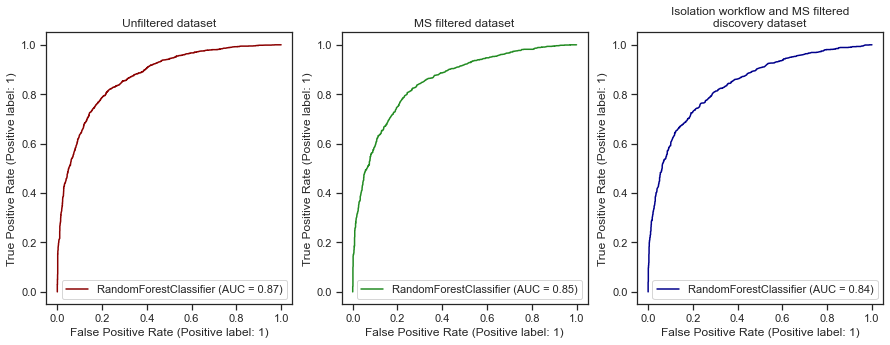

In [10]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(15,5))

RocCurveDisplay.from_estimator(rf_1, test_X_1, test_y_1, color="darkred", ax=ax[0])
ax[0].set(title="Unfiltered dataset")
RocCurveDisplay.from_estimator(rf_2, test_X_2, test_y_2, color="forestgreen", ax=ax[1])
ax[1].set(title="MS filtered dataset")
RocCurveDisplay.from_estimator(rf_3, test_X_3, test_y_3, color="darkblue", ax=ax[2])
ax[2].set(title="Isolation workflow and MS filtered\ndiscovery dataset")

plt.show()

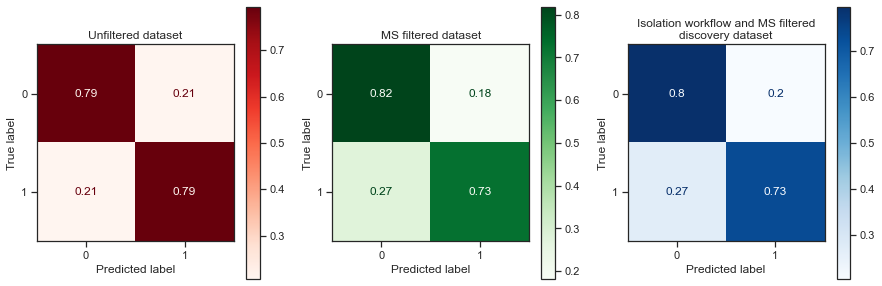

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ConfusionMatrixDisplay.from_estimator(rf_1, test_X_1, test_y_1, normalize="true", cmap=plt.cm.Reds, ax=ax[0])
ax[0].set(title="Unfiltered dataset")
ConfusionMatrixDisplay.from_estimator(rf_2, test_X_2, test_y_2, normalize="true", cmap=plt.cm.Greens, ax=ax[1])
ax[1].set(title="MS filtered dataset")
ConfusionMatrixDisplay.from_estimator(rf_3, test_X_3, test_y_3, normalize="true", cmap=plt.cm.Blues, ax=ax[2])
ax[2].set(title="Isolation workflow and MS filtered\ndiscovery dataset")

plt.show()

### Sequence-based features

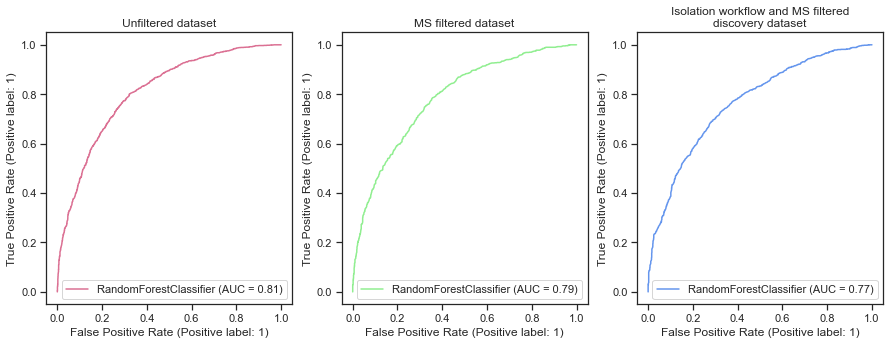

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

RocCurveDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, color="palevioletred", ax=ax[0])
ax[0].set(title="Unfiltered dataset")
RocCurveDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, color="lightgreen", ax=ax[1])
ax[1].set(title="MS filtered dataset")
RocCurveDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, color="cornflowerblue", ax=ax[2])
ax[2].set(title="Isolation workflow and MS filtered\ndiscovery dataset")

plt.show()

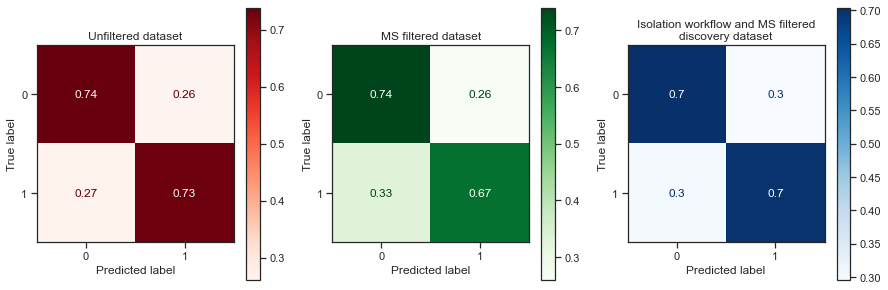

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ConfusionMatrixDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, normalize="true", cmap=plt.cm.Reds, ax=ax[0])
ax[0].set(title="Unfiltered dataset")
ConfusionMatrixDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, normalize="true", cmap=plt.cm.Greens, ax=ax[1])
ax[1].set(title="MS filtered dataset")
ConfusionMatrixDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, normalize="true", cmap=plt.cm.Blues, ax=ax[2])
ax[2].set(title="Isolation workflow and MS filtered\ndiscovery dataset")

plt.show()

### Model comparison

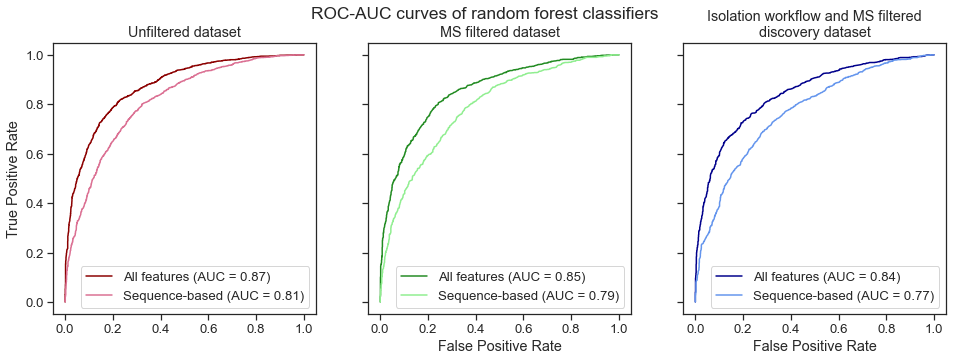

In [14]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

RocCurveDisplay.from_estimator(rf_1, test_X_1, test_y_1, color='darkred', name="All features", ax=ax1)
RocCurveDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, color='palevioletred', name="Sequence-based", 
                               ax=ax1)
ax1.set(xlabel=None, ylabel="True Positive Rate", title="Unfiltered dataset")
RocCurveDisplay.from_estimator(rf_2, test_X_2, test_y_2, color='forestgreen', name="All features", ax=ax2)
RocCurveDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, color='lightgreen', name="Sequence-based", ax=ax2)
ax2.set(xlabel="False Positive Rate", ylabel=None, title="MS filtered dataset")
RocCurveDisplay.from_estimator(rf_3, test_X_3, test_y_3, color='darkblue', name="All features", ax=ax3)
RocCurveDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, color='cornflowerblue', name="Sequence-based", ax=ax3)
ax3.set(xlabel="False Positive Rate", ylabel=None, title="Isolation workflow and MS filtered\ndiscovery dataset")
fig.suptitle("ROC-AUC curves of random forest classifiers")

plt.show()

## Feature importance

In [15]:
feature_dict = {'Palmitoylation_all':'Palmitoylation¹', 
                'PTM_Uniprot':'PTM¹', 
                'molecular_weight':'Molecular weight',
                'Instability_index':'Instability index',
                'length':'Sequence length', 
                'turn':'Turn', 
                'Acetylation_all':'Acetylation¹',
                'tasa_netsurfp2':'TASA', 
                'thsa_netsurfp2':'THSA',
                'disorder':'Disorder', 
                'D_exposed':'Exposed D', 
                'Ubiquitination_all':'Ubiquitination¹', 
                'sheet':'Sheet', 
                'Sum_AA_exposed': 'Exposed residues', 
                'S_exposed':'Exposed S', 
                'Aggregation_propensity':'Aggregation propensity',
                'L_exposed':'Exposed L', 
                'rhsa_netsurfp2':'RHSA', 
                'Isoelectric_point':'Isoelectric point', 
                'Charge_at_7':'Charge at pH 7',
                'on_surface': 'Hydrophobic residues on surface', 
                'Methylation_all':'Methylation¹', 
                'Charge_at_5':'Charge at pH 5', 
                'helix':'Helix',
                'hydr_count':'Hydrophobic residues', 
                'G_exposed':'Exposed G', 
                'H_exposed':'Exposed H',
                'Q_exposed':'Exposed Q', 
                'N_exposed':'Exposed N', 
                'C_exposed':'Exposed C', 
                'A_exposed':'Exposed A', 
                'K_exposed':'Exposed K', 
                'V_exposed':'Exposed V', 
                'E_exposed':'Exposed E', 
                'M_exposed':'Exposed M', 
                'T_exposed':'Exposed T', 
                'Glycosylation_all':'Glycosylation¹', 
                'R_exposed':'Exposed R', 
                'P_exposed':'Exposed P', 
                'Y_exposed':'Exposed Y',
                'polar_count':'Polar residues', 
                'F_exposed':'Exposed F', 
                'I_exposed':'Exposed I', 
                'Nitrosylation_all':'Nitrosylation¹',
                'W_exposed':'Exposed W', 
                'Acetylation_MSD':'Acetylation predicted', 
                'Phosphorylation_all':'Phosphorylation¹', 
                'transmembrane':'Transmembrane',
                'SUMOylation_MSD':'SUMOylation predicted', 
                'Methylation_MSD':'Methylation predicted', 
                'Palmitoylation_MSD':'Palmitoylation predicted', 
                'coiled_coil': 'Coiled coil domain', 
                'Lipoprotein_UP':'Lipoprotein¹', 
                'Glycosylation_MSD':'Glycosylation predicted',
                'SUMOylation_all':'SUMOylation¹',
                'Phosphorylation_MSD':'Phosphorylation predicted',
                'Ubiquitination_MSD':'Ubiquitination predicted',
                'PTM_MSD':'PTM predicted',
                'Myristoylation_all':'Myristoylation¹', 
                'Prenylation_Uniprot':'Prenylation¹', 
                'GPI-anchor_Uniprot':'GPI-anchor¹', 
                'ww_domain':'WW domain',
                'NEDDylation_Uniprot':'NEDDylation¹', 
                'RAS_profile':'RAS profile', 
                'Citrullination_Uniprot':'Citrullination¹', 
                'Nitration_Uniprot':'Nitration¹',
                'ISGylation_Uniprot':'ISGylation¹',
                'HSP':'HSP¹',
                'Polar_exposed':'Exposed polar residues',
                'Hydrophobic_exposed':'Exposed hydrophobic residues'}

### All features

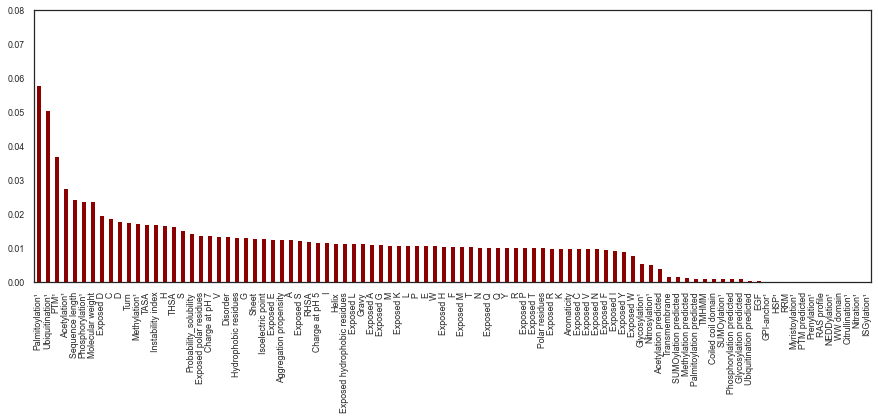

In [16]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_1.columns]

feature_importance_rf1 = pd.DataFrame(data={"Importance":rf_1.feature_importances_}, index=col_names)
feature_importance_rf1["Importance"].sort_values(ascending=False).plot(kind='bar', color='darkred')
ax.set_ylim((0,0.08))

plt.show()

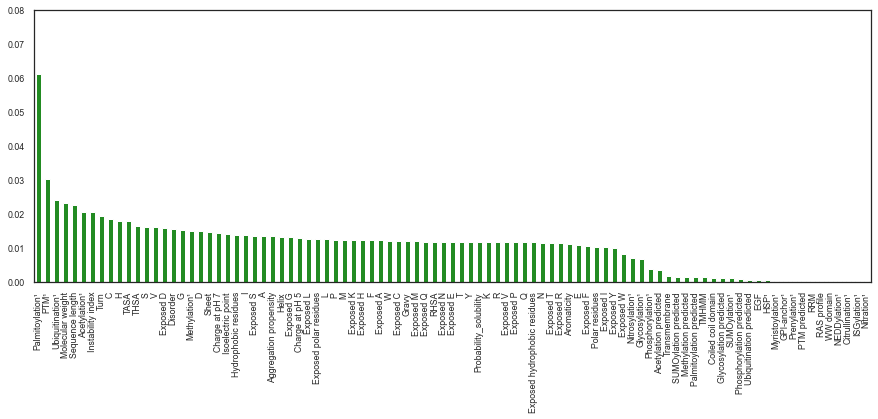

In [17]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_2.columns]

feature_importance_rf2 = pd.DataFrame(data={"Importance":rf_2.feature_importances_}, index=col_names)
feature_importance_rf2["Importance"].sort_values(ascending=False).plot(kind='bar', color='forestgreen')
ax.set_ylim((0,0.08))

plt.show()

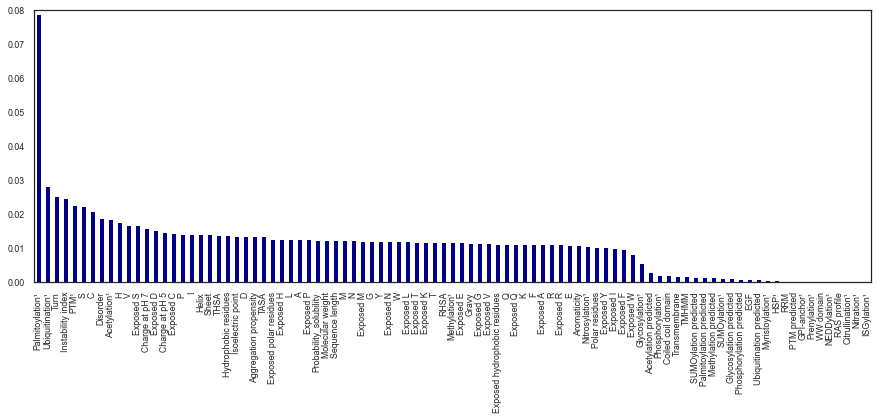

In [18]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_3.columns]

feature_importance_rf3 = pd.DataFrame(data={"Importance":rf_3.feature_importances_}, index=col_names)
feature_importance_rf3["Importance"].sort_values(ascending=False).plot(kind='bar', color='darkblue')
ax.set_ylim((0,0.08))

plt.show()

### Sequence-based features

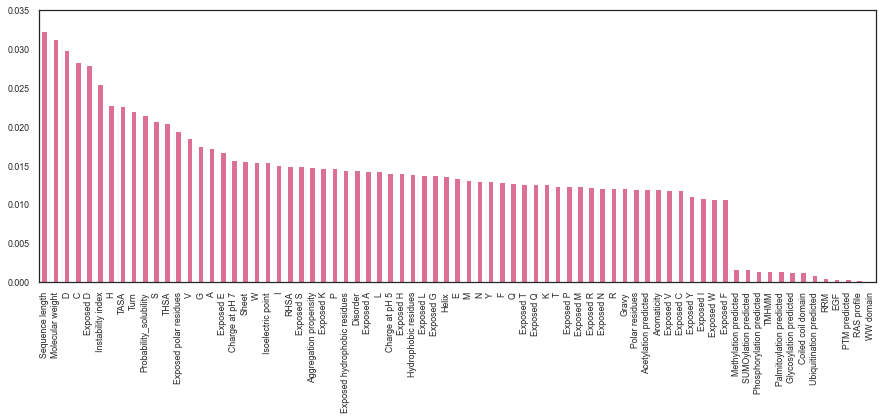

In [19]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_1_seq.columns]

feature_importance_rf1_seq = pd.DataFrame(data={"Importance":rf_1_seq.feature_importances_}, index=col_names)
feature_importance_rf1_seq["Importance"].sort_values(ascending=False).plot(kind='bar', color='palevioletred')
ax.set_ylim((0,0.035))

plt.show()

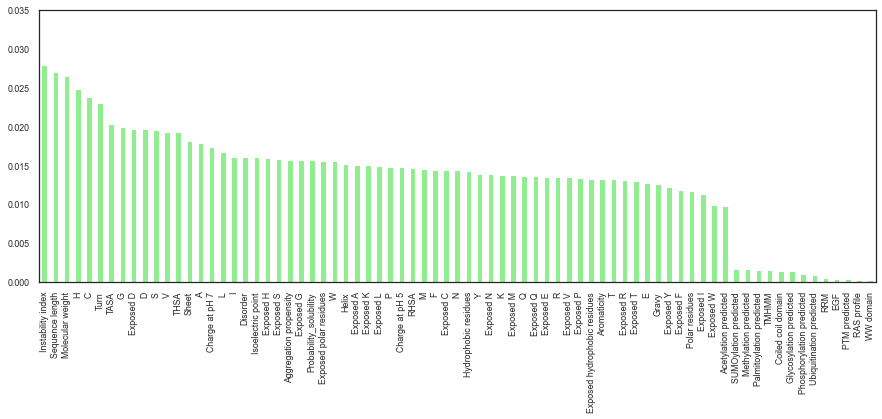

In [20]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_2_seq.columns]

feature_importance_rf2_seq = pd.DataFrame(data={"Importance":rf_2_seq.feature_importances_}, index=col_names)
feature_importance_rf2_seq["Importance"].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
ax.set_ylim((0,0.035))

plt.show()

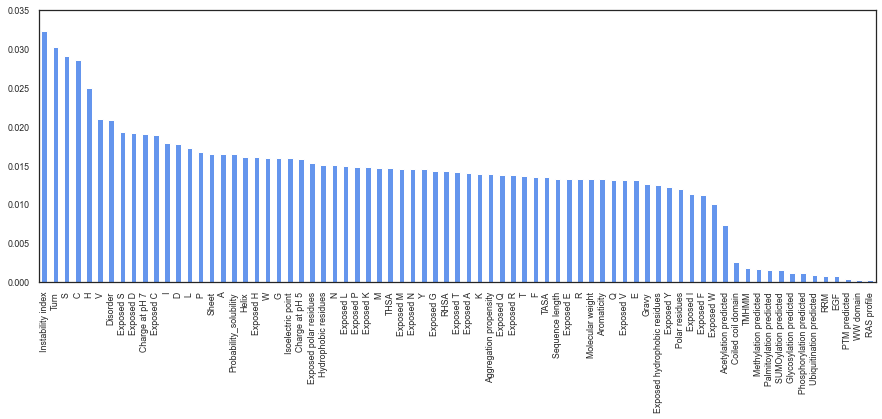

In [21]:
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(1, 1, figsize=(15,5))

col_names = [feature_dict[x] if x in feature_dict.keys() else x for x in train_X_3_seq.columns]

feature_importance_rf3_seq = pd.DataFrame(data={"Importance":rf_3_seq.feature_importances_}, index=col_names)
feature_importance_rf3_seq["Importance"].sort_values(ascending=False).plot(kind='bar', color='cornflowerblue')
ax.set_ylim((0,0.035))

plt.show()

In [22]:
# create dataframe of feature importances
df_FI = feature_importance_rf3
df_FI = df_FI.join(feature_importance_rf2, lsuffix='_RF3')
df_FI = df_FI.join(feature_importance_rf1, lsuffix='_RF2', rsuffix='_RF1')
df_FI_sorted = df_FI.sort_values("Importance_RF3", ascending=False)
df_FI_sorted.reset_index(inplace=True)
df_FI_sorted.columns = ['Feature', 'Isolation workflow and MS filtered', 'MS filtered', 'Unfiltered']

# created melted dataframe for top 20 features
df_FI_top_melted = df_FI_sorted[:20].melt(id_vars=['Feature'], var_name='Filter',
    value_vars=['Isolation workflow and MS filtered', 'MS filtered', 'Unfiltered'], value_name='Importance')
df_FI_top_melted[:5]

,Feature,Filter,Importance
0,Palmitoylation¹,Isolation workflow and MS filtered,0.078794
1,Ubiquitination¹,Isolation workflow and MS filtered,0.028245
2,Turn,Isolation workflow and MS filtered,0.025066
3,Instability index,Isolation workflow and MS filtered,0.024516
4,PTM¹,Isolation workflow and MS filtered,0.022385


## Feature correlation

In [23]:
# retrieve pairwise feature correlation
corr_MS_iso = df_MS_iso_filter.corr()
corr_MS = df_MS_filter.corr()
corr_unfiltered = df_unfiltered.corr()

# create dataframe of feature correlations
df_corr = corr_MS_iso[['EV']]
df_corr = df_corr.join(corr_MS[['EV']], lsuffix='_3')
df_corr = df_corr.join(corr_unfiltered[['EV']], lsuffix='_2', rsuffix='_1')
df_corr.rename(index=feature_dict, inplace=True)

In [24]:
# change order of correlation values to feature importance ranking
df_corr_sorted = df_corr.reindex(df_FI_sorted["Feature"])
df_corr_sorted.reset_index(inplace=True)
df_corr_sorted.columns = ['Feature', 'Isolation workflow and MS filtered', 'MS filtered', 'Unfiltered']

# created melted dataframe for top 20 features
df_corr_top_melted = df_corr_sorted[:20].melt(id_vars=['Feature'], var_name='Filter', 
    value_vars=['Isolation workflow and MS filtered', 'MS filtered', 'Unfiltered'], value_name='Correlation')
df_corr_top_melted[:5]

,Feature,Filter,Correlation
0,Palmitoylation¹,Isolation workflow and MS filtered,0.426463
1,Ubiquitination¹,Isolation workflow and MS filtered,0.264611
2,Turn,Isolation workflow and MS filtered,-0.199371
3,Instability index,Isolation workflow and MS filtered,-0.216693
4,PTM¹,Isolation workflow and MS filtered,0.228689


## Model comparison

### Feature importance and correlation

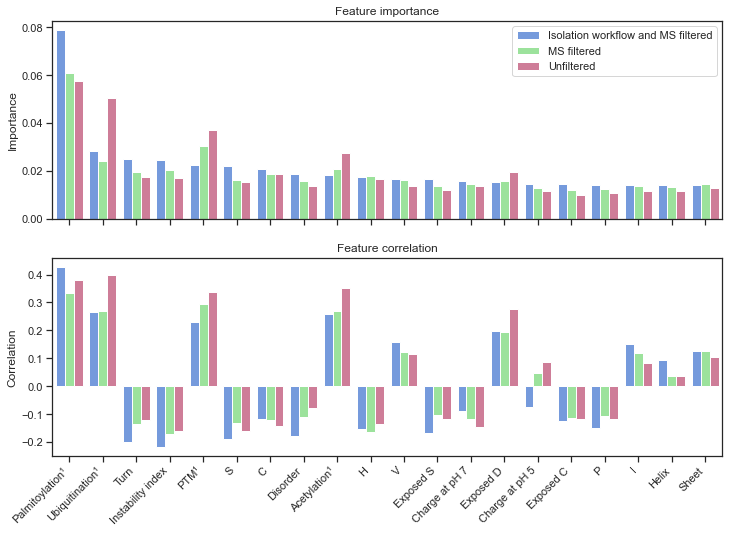

In [25]:
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)

# set colors for filter types
palette = {'Isolation workflow and MS filtered': 'cornflowerblue', 
           'MS filtered': 'lightgreen', 
           'Unfiltered': 'palevioletred'}

# plot feature importance (top 20)
bar = sns.barplot(x="Feature", y="Importance", data=df_FI_top_melted, hue="Filter", palette=palette, ax= axs[0])
bar.legend(title="")
bar.set(xlabel=None, ylabel="Importance", title="Feature importance", xticklabels=[])

# plot corresponding correlation
bar = sns.barplot(x="Feature", y="Correlation", data=df_corr_top_melted, hue="Filter", palette=palette, ax= axs[1])
bar.legend()
bar.set(xlabel=None, ylabel="Correlation", title="Feature correlation")
axs[1].set_xticklabels(df_corr_top_melted["Feature"][:20], rotation = 45, ha="right")
axs[1].get_legend().remove()

plt.show()

In [26]:
df_FI_top_melted_RF3 = df_FI_top_melted[df_FI_top_melted["Filter"] == "Isolation workflow and MS filtered"]
df_corr_top_melted_RF3 = df_corr_top_melted[df_corr_top_melted["Filter"] == "Isolation workflow and MS filtered"]

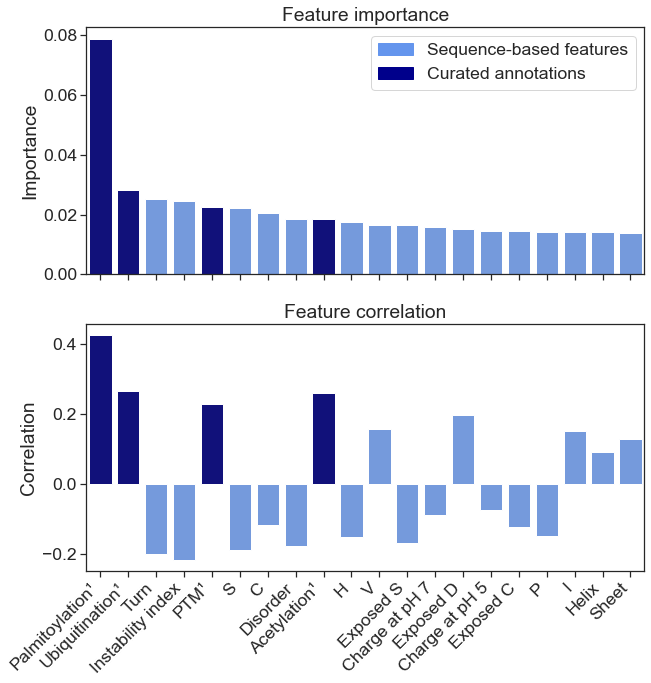

In [27]:
sns.set(style=("ticks"), font_scale=1.6)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.2)

pal=["darkblue", "darkblue", "cornflowerblue", "cornflowerblue", "darkblue", "cornflowerblue", "cornflowerblue",  
     "cornflowerblue", "darkblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue",
     "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue",
     "cornflowerblue"]

# plot feature importance (top 20)
bar = sns.barplot(x="Feature", y="Importance", data=df_FI_top_melted_RF3, palette=pal, ax=axs[0])
bar.set(xlabel=None, ylabel="Importance", title="Feature importance", xticklabels=[])

# create legend
seq_feat = patches.Patch(color="cornflowerblue", label="Sequence-based features")
all_feat = patches.Patch(color="darkblue", label="Curated annotations")
bar.legend(handles=[seq_feat, all_feat])

# plot corresponding correlation
bar = sns.barplot(x="Feature", y="Correlation", data=df_corr_top_melted_RF3, palette=pal, ax=axs[1])
bar.set(xlabel=None, ylabel="Correlation", title="Feature correlation")
axs[1].set_xticklabels(df_corr_top_melted["Feature"][:20], rotation=45, ha="right")
bar.legend(handles=[seq_feat, all_feat]).remove()

plt.show()

### Feature importance rank

In [28]:
# create data frame of all feature importance ranks
df_FI_rank = df_FI_sorted.copy()
df_FI_rank['Isolation workflow and MS filtered'] = df_FI_sorted['Isolation workflow and MS filtered'].rank()
df_FI_rank['MS filtered'] = df_FI_sorted['MS filtered'].rank()
df_FI_rank['Unfiltered'] = df_FI_sorted['Unfiltered'].rank()
df_FI_rank.set_index("Feature", inplace=True)

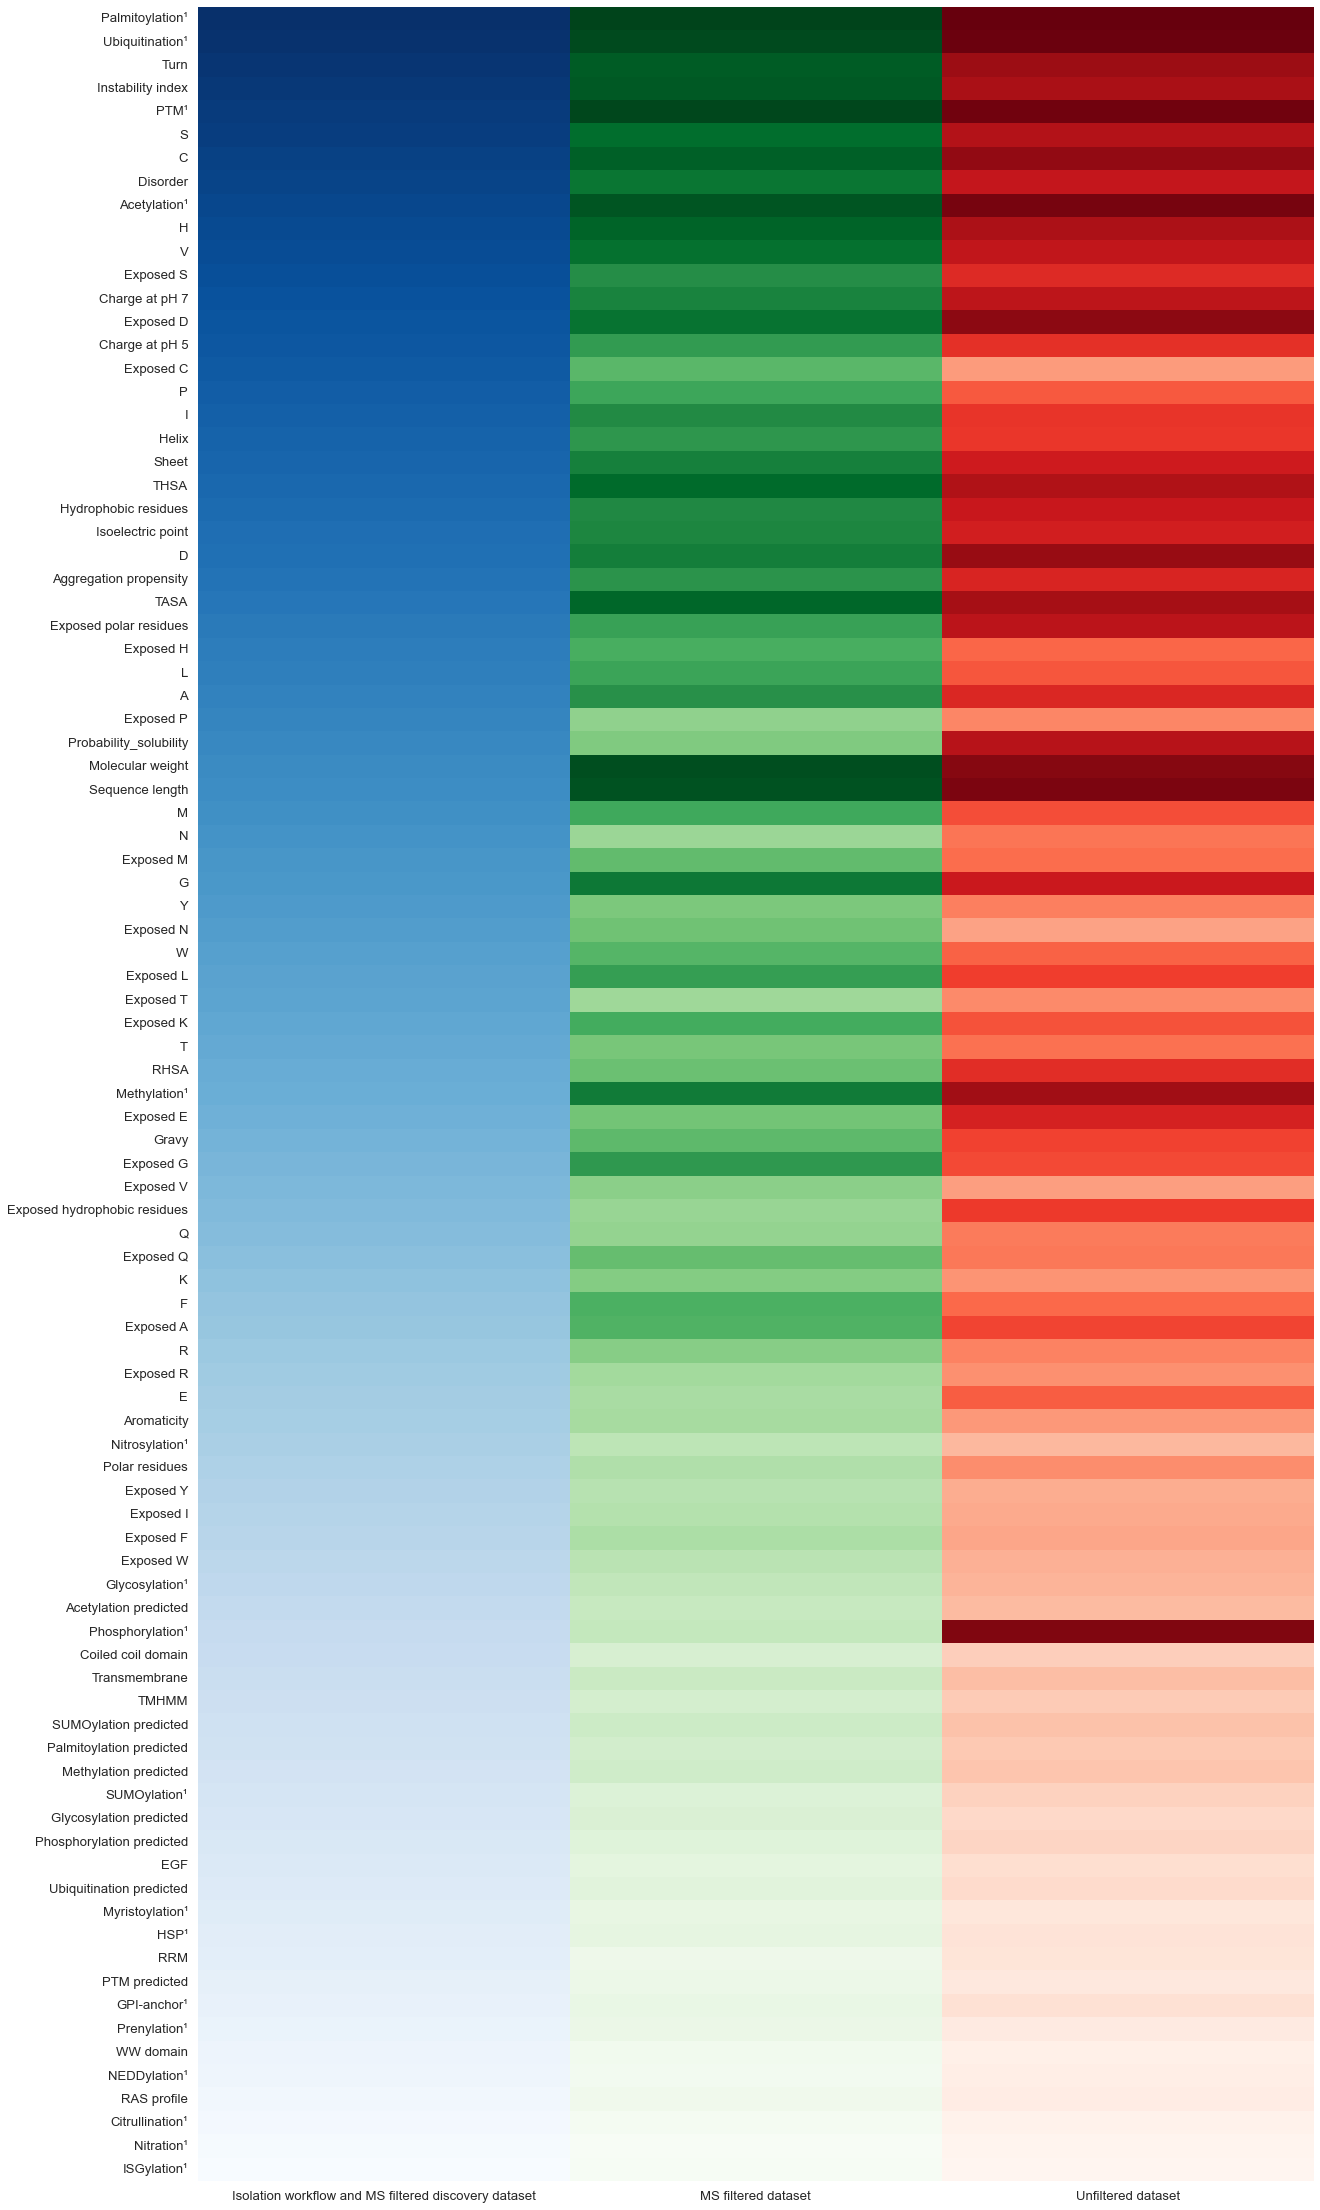

In [29]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(1, df_FI_rank.columns.size, gridspec_kw={'wspace': 0}, figsize=(20, 40))

cm = ['Blues', 'Greens', 'Reds']
classes = [["Isolation workflow and MS filtered discovery dataset"], 
           ["MS filtered dataset"], 
           ["Unfiltered dataset"]]

for i, (s, a, c) in enumerate(zip(df_FI_rank.columns, ax, cm)):
    sns.heatmap(np.array([df_FI_rank[s].values]).T, yticklabels=df_FI_rank.index, xticklabels=classes[i], fmt='.2f',
        ax=a, cmap=c, cbar=False)
    a.xaxis.set()
    if i>0:
        a.yaxis.set_ticks([])

# Create feature summary file

In [30]:
# load files from other notebooks
df_FI_random = pd.read_csv(os.getcwd() + '/Appendix/FI_Random_model.csv', index_col=0)
df_p_vals = pd.read_csv(Data_path + '/MS_iso_filter_P_values.csv', index_col=0)

# rename index names
df_p_vals.rename(index=feature_dict, inplace=True)

In [31]:
other = [df_corr[["EV_3"]], df_FI[["Importance_RF3"]], df_FI_random[["Importance_RF3_random"]]]

df_summary = df_p_vals[["P_value_adjusted"]].join(other, how="inner")
df_summary.columns = ['Adjusted P-value (EV vs. non-EV)', 'Correlation with EV class', 'Feature importance (Trained model)',
                     'Feature importance (Random model)']

df_summary.sort_values(by="Feature importance (Trained model)", ascending=False)[:5]

,Adjusted P-value (EV vs. non-EV),Correlation with EV class,Feature importance (Trained model),Feature importance (Random model)
Palmitoylation¹,0.000000e+00,0.426463,0.078794,0.001800
Ubiquitination¹,9.081945e-264,0.264611,0.028245,0.001840
Turn,1.103623e-158,-0.199371,0.025066,0.015356
Instability index,2.940746e-194,-0.216693,0.024516,0.017035
PTM¹,2.199860e-199,0.228689,0.022385,0.001755


In [32]:
df_summary.to_csv(Data_path + '/Feature_summary.csv')